In [2]:
from resources import *

/Users/pataan/Dropbox/DPhil/DAPPER


DAPPER is a collection of tools to do benchmarking to investigate the impact of DA.

Benchmarking by "twin experiments" enables assessing the
 * impact of DA on models
 * performance of different DA methods
 
A twin experiment is structured as illustrated in the [previous section](T6 - Writing your own EnKF.ipynb). I.e. you
* specify a
	* dynamic model* 
	* observational model*
* use these to generate a synthetic
	* "truth"
	* and observations thereof*
* assess how different DA methods perform in estimating the truth, given the above starred (*) items.




The experiment of the previous section was sourced from reseach litterature (Sakov, Oliver, Bertino (2012). "An iterative EnKF for strongly nonlinear systems." Monthly Weather Review). It's transcribed in DAPPER, and may be found at: `[DAPPER-path]/mods/Lorenz63/sak12.py`
Have a look (through your Jupyter dashboard). Note
 * DAPPER uses the transpose orientation for ensemble matrices $\mathbf{E}$ compared to earlier in this tutorial (and EnKF litterature). This simplifies a lot of the code, but is something one must be aware of.
 * The `'jacob'` entries are there to allow using DA methods such as the (extended) Kalman filter.
 * Shortcut notation is sometimes allowed (such as `noise=0`), as this gets processed by object constructors.
 

### Setup

In [22]:
from mods.Lorenz63.sak12 import setup
setup.t.K = 1500  # shorten experiment

We can inspect the setup by printing it

In [7]:
setup

<TwinSetup>: Lorenz63/sak12.py
.  f: 
.     <Operator>
.     .  jacob: <function dfdx at 0x1151e9510>
.     .  m: 3
.     .  model: <function step at 0x1151e9b70>
.     .  noise: 
.     .     <GaussRV>
.     .     .  m: 3
.     .     .  C: 0
.     .     .  mu: array([ 0.,  0.,  0.])
.  h: 
.     <Operator>
.     .  jacob: <NamedFunc>(x,t): Id(3) matrix
.     .  m: 3
.     .  model: <NamedFunc>(): Id operator
.     .  noise: 
.     .     <GaussRV>
.     .     .  m: 3
.     .     .  mu: array([ 0.,  0.,  0.])
.     .     .  C: 
.     .     .     <CovMat>
.     .     .           m: 3
.     .     .        kind: 'diag'
.     .     .       trunc: 1.0
.     .     .          rk: 3
.     .     .        full:
.     .     .          [[ 2.  0.  0.]
.     .     .           [ 0.  2.  0.]
.     .     .           [ 0.  0.  2.]]
.     .     .        diag:
.     .     .           [ 2.  2.  2.]
.  t: 
.     <Chronology>
.           K: 1500
.        KObs: 59
.           T: 15.0
.      BurnIn: 4
.       dt

### DA method

The other half of the preparation is to specify a DA method and its configuration.

In [9]:
config = EnKF('PertObs',N=10,infl=1.04,store_u=1)

The methods are defined in `[DAPPER-path]/da_methods.py`.

### Run experiment

The rest of the experiment can be found in `[DAPPER-path]/example_1.py`. It is copy-pasted below. Run it.

In [17]:
# Simulate synthetic truth (xx) and noisy obs (yy)
xx,yy = simulate(setup)

# Assimilate yy (knowing the twin setup). Assess vis-a-vis xx.
stats = config.assimilate(setup,xx,yy)

# Average stats time series
avrgs = stats.average_in_time()

### Get results

The averages may be neatly displayed using `print_averages`, as follows

In [20]:
print_averages(config,avrgs,[],['rmse_a','rmv_a'])

     da_method   N  upd_a    infl  |  rmse_a ±      rmv_a ±
---  ---------  --  -------  ----  -  -----------  -----------
[0]  EnKF       10  PertObs  1.04  |  0.6827 0.06  0.7079 0.04


**Exc:**
There are also other statistics in `stats` (and their time-averages in `avrgs`).
 * (a). The subscript `_a` in the average statistics listed above indicate that the statistics were collected immediately following an **a**nalysis update. Instead of these, print the **f**orecast (`_f`) statistics (collected immediately before the analysis. Are they lower/higher? Why?

 * (b). Display all of the averages by executing `avrgs`.

In [30]:
avrgs

AlignedDict(**{
    skew_a: val_with_conf(val=-0.02, conf=0.05),
   skew_f: val_with_conf(val=0.06, conf=0.07),
   skew_u: val_with_conf(val=0.04, conf=0.06),
   kurt_a: val_with_conf(val=-1.1, conf=0.1),
   kurt_f: val_with_conf(val=-0.9, conf=0.2),
   kurt_u: val_with_conf(val=-1.08, conf=0.09),
     trHK: val_with_conf(val=0.25, conf=0.02),
     infl: val_with_conf(val=nan, conf=nan),
 logp_m_a: val_with_conf(val=0.7, conf=0.3),
 logp_m_f: val_with_conf(val=1.3, conf=0.4),
 logp_m_u: val_with_conf(val=1.0, conf=0.4),
   rmse_a: val_with_conf(val=0.68, conf=0.06),
   rmse_f: val_with_conf(val=1.3, conf=0.2),
   rmse_u: val_with_conf(val=0.9, conf=0.1),
    rmv_a: val_with_conf(val=0.71, conf=0.04),
    rmv_f: val_with_conf(val=1.6, conf=0.2),
    rmv_u: val_with_conf(val=1.0, conf=0.1)
})

Raw access to the time-series of statistics is through `stats.MYSTAT.X`, where `X` is either `a`, `f` or `u`. The `u` attribute refers to time series registered at every integration step (not just before/after analyses), but is only present if the DA method was configured with `store_u=True`).

In addition, DAPPER has some tools to plot some default diagnostics. For example:

<IPython.core.display.Javascript object>


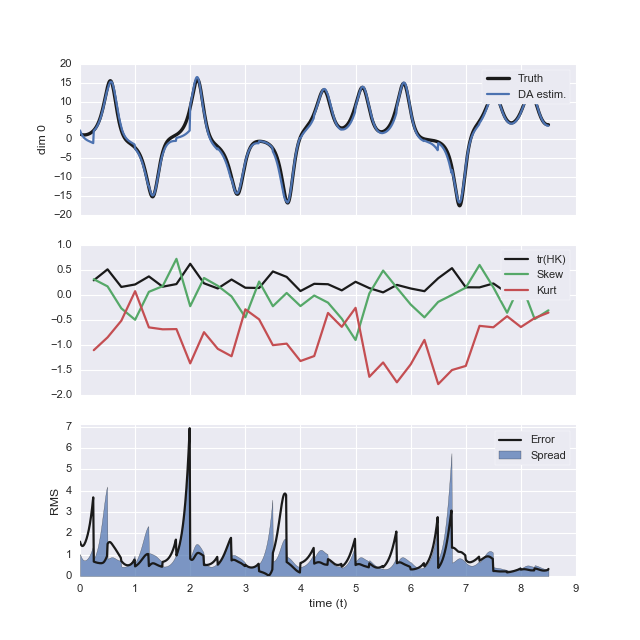

In [15]:
plot_time_series(stats)

**Exc:** Why are the diagnostics in the middle plot are sharper (more jagged) than the others ?

In [47]:
answers['jagged diagnostics'] = ['MD',r'''
Because they are only defined at analysis times, i.e. every `dkObs` time step.
''']
show_answer('jagged diagnostics')

In [1]:
plot_3D_trajectory (stats)

NameError: name 'plot_3D_trajectory' is not defined

<IPython.core.display.Javascript object>


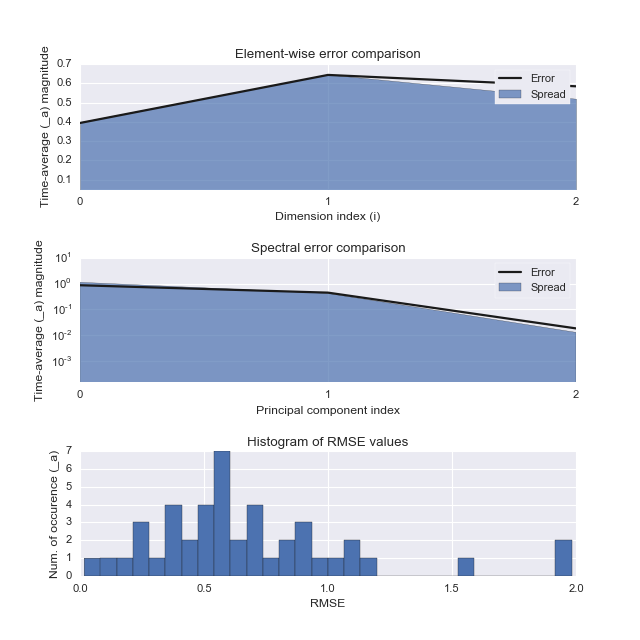

In [40]:
plot_err_components(stats)

**Exc:** What is the probability law of RMSE values? What does this presuppose?

In [43]:
answers['RMSE hist'] = ['MD',r'''
 * (Something close to) chi-square.
 * Gaussianity
''']
show_answer('RMSE hist')

<IPython.core.display.Javascript object>


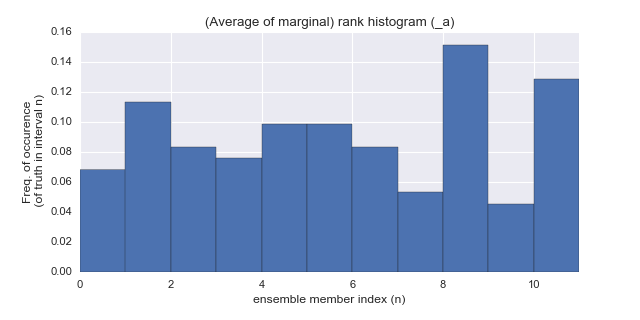

In [42]:
plot_rank_histogram(stats)

**Exc:** Does this indicate that the filter is to confident or too uncertain?

In [46]:
answers['Rank hist'] = ['MD',r'''
 * U-shaped: Too confident
 * A-shaped: Too uncertain
 * Flat: well calibrated
''']
show_answer('Rank hist')

**Exc:** Do a twin experiment with the setup from mods.Lorenz95.sak08. The same file also holds several DA method configurations to test with.
If you're running it locally, do this outside of jupyter, and use the setting `liveplotting=True` for the DA configuration.

**Exc:** Do the same experiment, but with a different DA configuration. There's a list of them in `[DAPPER-path]/example_1.py`.